In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.animation as ani

import sys
sys.path.append('../python/')
import NGC5533_functions as nf
import fitting_NGC5533 as fitting

In [2]:
#v = sqrt(GMenc/r)
#Menc = (v^2 r) / G

#    Black hole mass: large point mass at center
#    Components: black hole bulge, disk, halo, gas
#    Take curve and put radius and velocities in two arrays. Calculate mass enclosed for each radius. 
#    Say one star has an average mass. Divide mass up into number of stars enclosed (this is for each radius calculated). Create for loop to put the star count per radius into an array where you start at zero radius put that value in the array, subtract the second from the first and put the difference value in an array. 
#    Random positions of these stars are needed. 
#    Make animation of these points going around the center with the velocities given. 

In [3]:
# Define components
def blackhole(r,M):
    return nf.bh_v(r,M,load=True)

def bulge(r,bpref):
    return bpref*nf.b_v(r,load=True)

def disk(r,dpref):
    return dpref*nf.d_thief(r)

def halo(r,rc,rho00):
    return nf.h_v(r,rc,rho00,load=True)

def gas(r,gpref):
    return gpref*nf.g_thief(r)

def totalcurve(r,M,bpref,dpref,rc,rho00,gpref):
    total = np.sqrt(blackhole(r,M)**2 
                    + bulge(r,bpref)**2 
                    + disk(r,dpref)**2
                    + halo(r,rc,rho00)**2
                    + gas(r,gpref)**2)
    return total

In [4]:
# Fitting parameters
M = fitting.f_M * 1.989e30
bpref = fitting.f_c
dpref = fitting.f_pref
rc = fitting.f_rc * 3.086e19
rho00 = fitting.f_hrho00
gpref = fitting.f_gpref

In [5]:
# Create arrays of all radii and velocities of each components
rad = np.linspace(0.1,100,100) * 3.086e19
blackhole = blackhole(rad,M)
bulge = bulge(rad,bpref)
disk = disk(rad,dpref)
halo = halo(rad,rc,rho00)
gas = gas(rad,gpref)
#totalcurve = totalcurve(rad,M,bpref,dpref,rc,rho00,gpref)

In [6]:
# Define N-body simulation functions
def forceMagnitude(m1,m2,r):
    G = 6.67408e-11    # m3 kg-1 s-2
    return G * m1 * m2 / r**2 # N

def magnitude(vector):
    return np.sqrt(np.sum(vector**2))

def unitDirectionVector(x,y):
    separation = y - x
    return separation/magnitude(separation)

def forceVector(m1,m2,x,y):
    distance = magnitude(x - y)
    force = forceMagnitude(m1,m2,distance)
    direction = unitDirectionVector(x,y)
    return force*direction 

def calculateForceVectors(masses, positions):
    N = len(positions)
    forcevectors = []

    for i in range(N):
        vector = np.zeros(3)
        for j in range(N):
            if j != i:
                vector += forceVector(masses[i], masses[j], positions[i], positions[j])
        forcevectors.append(vector)
    
    return forcevectors

def updateParticles(masses, positions, velocities, dt):
    startingPositions = np.array(positions)
    startingVelocities = np.array(velocities)
    
    nParticles, nDimensions = startingPositions.shape
    
    assert(startingVelocities.shape == startingPositions.shape)
    assert(len(masses) == nParticles)

    startingForces = np.array(calculateForceVectors(masses, startingPositions))
        
    startingAccelerations = startingForces/np.array(masses).reshape(nParticles, 1)
    
    nudge = startingVelocities*dt + 0.5*startingAccelerations*dt**2
    endingPositions = startingPositions + nudge

    endingForces = np.array(calculateForceVectors(masses, endingPositions))

    endingAccelerations = endingForces/np.array(masses).reshape(nParticles, 1)

    endingVelocities = (startingVelocities +
                        0.5*(endingAccelerations + startingAccelerations)*dt)

    return endingPositions, endingVelocities

def calculateTrajectories(masses, initialPositions, initialVelocities, totalTime, dt):

    newPositions = [initialPositions]
    newVelocities = [initialVelocities]
    nTimes = [0]
    
    lastPosition = np.array(initialPositions)
    lastVelocity = np.array(initialVelocities)
    
    trackTime = 0
        
    while trackTime < totalTime:
        
        calcParticles = updateParticles(masses, lastPosition, lastVelocity, dt)
        trackTime += dt
        
        lastPosition = calcParticles[0]
        lastVelocity = calcParticles[1]
        newPositions.append(lastPosition)
        newVelocities.append(lastVelocity)
        nTimes.append(trackTime)
     
    newPositions = np.array(newPositions)        
    newVelocities = np.array(newVelocities)
    nTimes = np.array(nTimes)
    
    return newPositions, newVelocities, nTimes

In [7]:
# Masses
massesBlackhole = np.array([M])
massesBulge = 5*np.ones(100) * 1.989e30
massesDisk = 5*np.ones(100) * 1.989e30
massesHalo = 5*np.ones(100) * 1.989e30
massesGas = np.ones(100) * 1.989e30

# Positions
def randomPositions(N,x0,y0,xstd,ystd):
    x = np.random.normal(loc=x0, scale=xstd, size=N)
    y = np.random.normal(loc=y0, scale=ystd, size=N)
    return x,y
    
positionBlackhole = np.array([0,0,0])

positionBulge = []
x = randomPositions(100,0,0,5,5)[0]
y = randomPositions(100,0,0,5,5)[1]
for i in range(len(x)):
    pos = x[i],y[i],0
    positionBulge.append(pos)
positionBulge = np.array(positionBulge) * 3.086e19

positionDisk = []
x = randomPositions(100,0,0,30,20)[0]
y = randomPositions(100,0,0,30,20)[1]
for i in range(len(x)):
    pos = x[i],y[i],0
    positionDisk.append(pos)
positionDisk = np.array(positionDisk) * 3.086e19

positionHalo = []
x = randomPositions(100,0,0,50,40)[0]
y = randomPositions(100,0,0,50,40)[1]
for i in range(len(x)):
    pos = x[i],y[i],0
    positionHalo.append(pos)
positionHalo = np.array(positionHalo) * 3.086e19

positionGas = []
x = randomPositions(100,0,0,40,30)[0]
y = randomPositions(100,0,0,40,30)[1]
for i in range(len(x)):
    pos = x[i],y[i],0
    positionGas.append(pos)
positionGas = np.array(positionGas) * 3.086e19

In [18]:
velocityBulge = []
x = randomPositions(100,0,0,5,5)[0]
y = randomPositions(100,0,0,5,5)[1]
for i in range(len(x)):
    pos = x[i],y[i],0
    velocityBulge.append(pos)
velocityBulge = np.array(velocityBulge) * 3.086e19

velocityDisk = []
x = randomPositions(100,0,0,30,20)[0]
y = randomPositions(100,0,0,30,20)[1]
for i in range(len(x)):
    pos = x[i],y[i],0
    velocityDisk.append(pos)
velocityDisk = np.array(velocityDisk) * 3.086e19

velocityHalo = []
x = randomPositions(100,0,0,50,40)[0]
y = randomPositions(100,0,0,50,40)[1]
for i in range(len(x)):
    pos = x[i],y[i],0
    velocityHalo.append(pos)
velocityHalo = np.array(velocityHalo) * 3.086e19

velocityGas = []
x = randomPositions(100,0,0,40,30)[0]
y = randomPositions(100,0,0,40,30)[1]
for i in range(len(x)):
    pos = x[i],y[i],0
    velocityGas.append(pos)
velocityGas = np.array(velocityGas) * 3.086e19

In [19]:
"""# Velocities                          
velocityBlackhole = np.array([0,0,0])

velocityBulge = []
for b,posb in zip(bulge,positionBulge):
    # velocity vector is perpendicular to position vector
    a = -posb[1]
    b = posb[0]
    c = 0
    vector = np.array([a,b,c])
    unitvector = vector/magnitude(vector)
    linear = b * unitvector
    velocityBulge.append(linear)
velocityBulge = np.array(velocityBulge) * 1e3

velocityDisk = []
for d,posd in zip(disk,positionDisk):     
    # velocity vector is perpendicular to position vector
    a = -posd[1]
    b = posd[0]
    c = 0
    vector = np.array([a,b,c])
    unitvector = vector/magnitude(vector)
    linear = d * unitvector
    velocityDisk.append(linear)
velocityDisk = np.array(velocityDisk) * 1e3

velocityHalo = []
for h,posh in zip(halo,positionHalo):   
    # velocity vector is perpendicular to position vector
    a = -posh[1]
    b = posh[0]
    c = 0
    vector = np.array([a,b,c])
    unitvector = vector/magnitude(vector)
    linear = h * unitvector
    velocityHalo.append(linear)
velocityHalo = np.array(velocityHalo) * 1e3

velocityGas = []
for g,posg in zip(gas,positionGas):   
    # velocity vector is perpendicular to position vector
    a = -posg[1]
    b = posg[0]
    c = 0
    vector = np.array([a,b,c])
    unitvector = vector/magnitude(vector)
    linear = g * unitvector
    velocityGas.append(linear)
velocityGas = np.array(velocityGas) * 1e3"""

'# Velocities                          \nvelocityBlackhole = np.array([0,0,0])\n\nvelocityBulge = []\nfor b,posb in zip(bulge,positionBulge):\n    # velocity vector is perpendicular to position vector\n    a = -posb[1]\n    b = posb[0]\n    c = 0\n    vector = np.array([a,b,c])\n    unitvector = vector/magnitude(vector)\n    linear = b * unitvector\n    velocityBulge.append(linear)\nvelocityBulge = np.array(velocityBulge) * 1e3\n\nvelocityDisk = []\nfor d,posd in zip(disk,positionDisk):     \n    # velocity vector is perpendicular to position vector\n    a = -posd[1]\n    b = posd[0]\n    c = 0\n    vector = np.array([a,b,c])\n    unitvector = vector/magnitude(vector)\n    linear = d * unitvector\n    velocityDisk.append(linear)\nvelocityDisk = np.array(velocityDisk) * 1e3\n\nvelocityHalo = []\nfor h,posh in zip(halo,positionHalo):   \n    # velocity vector is perpendicular to position vector\n    a = -posh[1]\n    b = posh[0]\n    c = 0\n    vector = np.array([a,b,c])\n    unitvector 

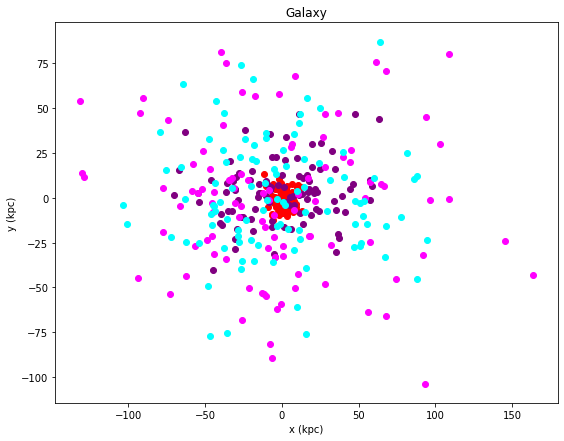

In [20]:
# Random Galaxy
bx = randomPositions(100,0,0,5,5)[0]
by = randomPositions(100,0,0,5,5)[1]
dx = randomPositions(100,0,0,30,20)[0]
dy = randomPositions(100,0,0,30,20)[1]
hx = randomPositions(100,0,0,50,40)[0]
hy = randomPositions(100,0,0,50,40)[1]
gx = randomPositions(100,0,0,40,30)[0]
gy = randomPositions(100,0,0,40,30)[1]

plt.figure(figsize=(9,7))
plt.title("Galaxy")
plt.xlabel("x (kpc)")
plt.ylabel("y (kpc)")
plt.scatter(bx,by, color='red')
plt.scatter(dx,dy, color='purple')
plt.scatter(hx,hy, color='magenta')
plt.scatter(gx,gy, color='cyan')
#plt.xlim(-0.015,0.015)
#plt.ylim(-0.015,0.015)

plt.show()

In [21]:
# Calculate trajectories
dt = 2e37                     # seconds (100 increments)
totalTime = 2e39              # seconds (should go spin about 4 times)

bulgeTrajectory = calculateTrajectories(massesBulge, positionBulge, velocityBulge, totalTime, dt)
diskTrajectory = calculateTrajectories(massesDisk, positionDisk, velocityDisk, totalTime, dt)
haloTrajectory = calculateTrajectories(massesHalo, positionHalo, velocityHalo, totalTime, dt)
gasTrajectory = calculateTrajectories(massesGas, positionGas, velocityGas, totalTime, dt)

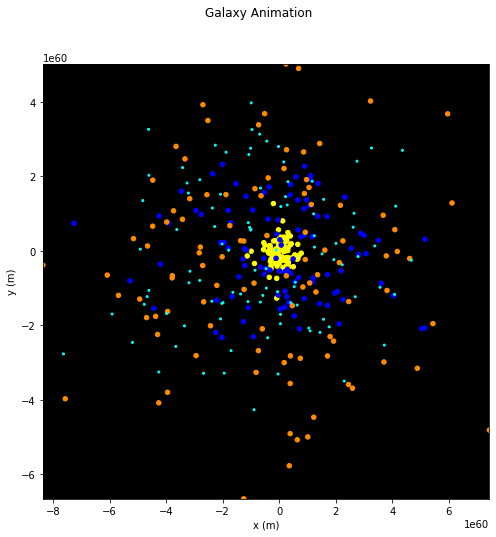

In [23]:
# create a movie write object, set frame rate
writer = ani.FFMpegWriter(fps=25)

# create a figure, 8"x8" in size
fig = plt.figure(figsize=(8,8))

# extract position from calculated trajectories
newpositionBulge = bulgeTrajectory[0]
newpositionDisk = diskTrajectory[0]
newpositionHalo = haloTrajectory[0]
newpositionGas = gasTrajectory[0]

# define size of dot
areaBlackhole = [m * 2e-30 for m in massesBlackhole]
areaBulge = [m * 2e-30 for m in massesBulge]
areaDisk = [m * 2e-30 for m in massesDisk]
areaHalo = [m * 2e-30 for m in massesHalo]
areaGas = [m * 2e-30 for m in massesGas]

# find min and max
xmin = np.min(newpositionHalo[:,:,0])
xmax = np.max(newpositionHalo[:,:,0])
ymin = np.min(newpositionHalo[:,:,1])
ymax = np.max(newpositionHalo[:,:,1])

# set things up to save frames to a movie:
#   fig = the figure the writer will record from
with writer.saving(fig, 'Galaxy.mp4', 100):
    
# loop 
    for posb,posd,posh,posg in zip(newpositionBulge,newpositionDisk,newpositionHalo,newpositionGas):
        
        # clear the previous plot
        plt.cla()
        
        plt.scatter(positionBlackhole[0], positionBlackhole[1], color=['black'], s=areaBlackhole)
        plt.scatter(posb[:,0], posb[:,1], color=['yellow'], s=areaBulge)
        plt.scatter(posd[:,0], posd[:,1], color=['blue'], s=areaDisk)
        plt.scatter(posh[:,0], posh[:,1], color=['darkorange'], s=areaHalo)
        plt.scatter(posg[:,0], posg[:,1], color=['cyan'], s=areaGas)
        plt.suptitle('Galaxy Animation')
        plt.xlabel('x (m)')
        plt.ylabel('y (m)')
        plt.xlim(xmin-0.1,xmax+0.1)
        plt.ylim(ymin-0.1,ymax+0.1)
    
        # save the current plot as a movie frame
        writer.grab_frame()